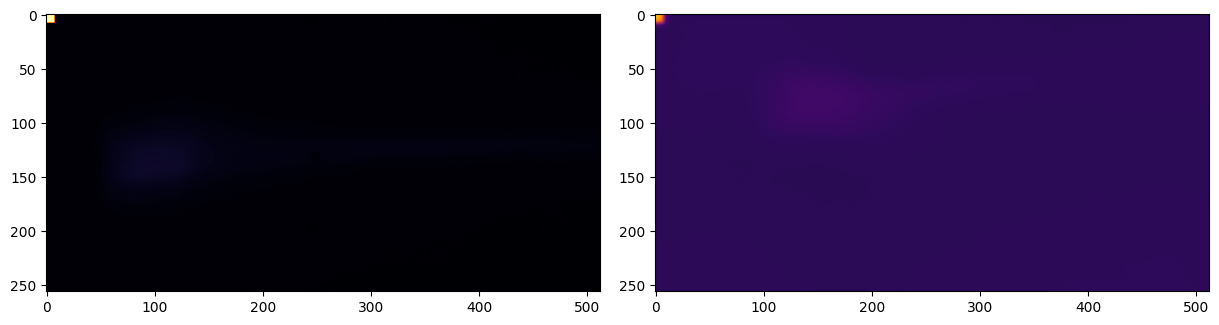

{'mse': tensor(6077.5381), 'mse_norm': tensor(0.0006), 'dtw_dist': 1594.645594982546, 'ssim': tensor(0.1608, dtype=torch.float64)}


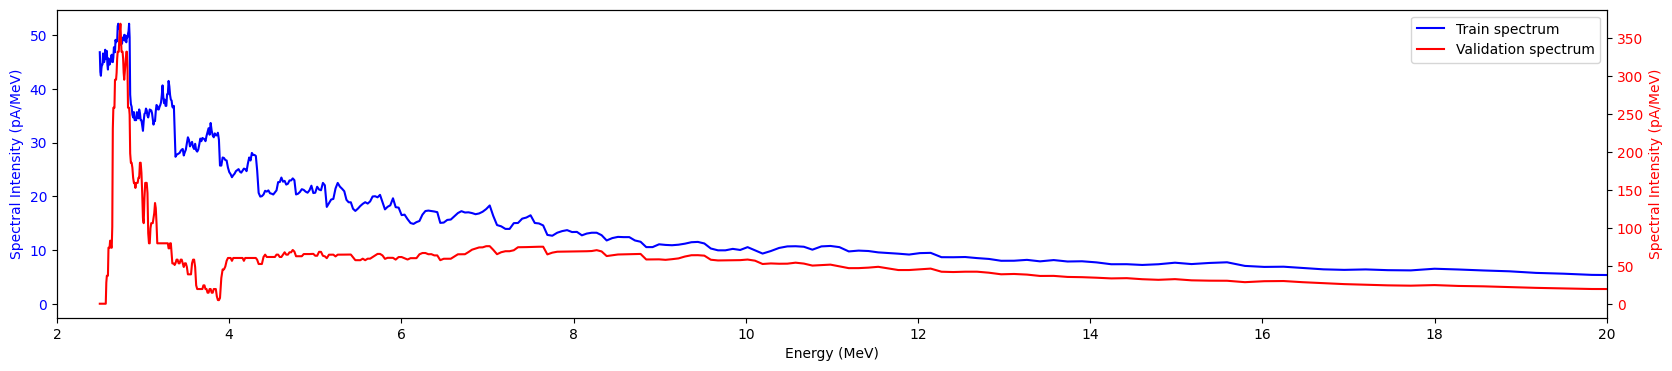

In [11]:
from metrics import *
import matplotlib.pyplot as plt
from src.utils import deflection_calc

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    # im2 *= 3
    # im2[:10, :10] = 255
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def plot_spectra(sp1, sp2, el_pointing_pixel=62, xlim=[2, 20]):
    fig, ax1 = plt.subplots(figsize=(20, 4))
    deflection_MeV = deflection_calc(1, len(sp1), el_pointing_pixel).flatten()
    
    # Plot the first sequence on the left y-axis
    ax1.plot(deflection_MeV, sp1, label='Train spectrum', color='blue')
    ax1.set_ylabel('Spectral Intensity (pA/MeV)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Energy (MeV)')
    ax1.set_xlim(xlim)
    
    # Create a second y-axis on the right side
    ax2 = ax1.twinx()
    
    # Plot the second sequence on the right y-axis
    ax2.plot(deflection_MeV, sp2, label='Validation spectrum', color='red')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()

# 3, 8, 11, 19, 21
dirnum = 19

dir1 = 'data/with_gain/' + str(dirnum)
# dir2 = 'results/valid_nophys_1000ns_sec25_cfg3/' + str(dirnum)
dir2 = 'results/valid_phys10th_850ns_sec1x9plus6_cfg5/' + str(dirnum)

res, spectra = compare_spectra(dir1, dir2, dirnum)
img1, img2 = compare_avg(dir1, dir2)
compare_avg_plot(img1, img2)
print(res)
plot_spectra(spectra['spectr_train'], spectra['spectr_valid'])

In [13]:
import pandas as pd


# Load the CSV file
file_path = 'metrics.csv'
df = pd.read_csv(file_path)

df.head()

# Process the first column to extract the required information
def extract_details(row):
    # Removing 'valid_' prefix and splitting the string
    parts = row.replace('valid_', '').split('_')

    # Extracting model type
    if 'nophys' in parts:
        model_type = 'nophys'
    elif 'phys10th' in parts and 'beam' not in parts:
        model_type = 'phys10th'
    else:
        model_type = 'phys10thbeam'

    # Extracting noise steps
    noise_steps = next((part for part in parts if part.endswith('ns')), None)

    # Extracting sections
    sections = next((part for part in parts if 'sec' in part), None)

    # Extracting CFG
    cfg = next((part for part in parts if part.startswith('cfg')), None)

    return model_type, noise_steps, sections, cfg

# Apply the function to the dataframe
df[['Model Type', 'Noise Steps', 'Sections', 'CFG']] = df.apply(lambda row: extract_details(row.iloc[0]), axis=1, result_type='expand')

# Rename the first column to remove 'valid_'
df.rename(columns={df.columns[0]: 'Description'}, inplace=True)
# Rename the numbers column to 'FID' and move it to the end
df.rename(columns={df.columns[1]: 'FID'}, inplace=True)

# Rearranging columns to move 'FID' to the end
column_order = ['Model Type', 'Noise Steps', 'Sections', 'CFG', 'FID']
df = df[column_order]

# Remove the 'Description' column
df.drop(columns=['Description'], inplace=True, errors='ignore')
# Extracting only the number from the 'CFG' column
df['CFG'] = df['CFG'].str.extract('(\d+)').astype(int)

# Function to transform the 'Sections' values
def transform_section(value):
    if value == 'sec1x9plus6':
        return '9+6'
    elif value == 'sec2x9plus7':
        return '18+7'
    else:
        # Extract only the number for other 'sec' values
        return ''.join(filter(str.isdigit, value))

# Apply the transformation to the 'Sections' column
df['Sections'] = df['Sections'].apply(transform_section)

df.head()
df.to_csv('results.csv')


In [2]:
import os
import pandas as pd
from metrics import *
from tqdm import tqdm

import os
import pandas as pd

def process_folder_results(results_dir):
    all_results = []

    # Loop through each main subfolder in results
    for main_folder_name in tqdm(os.listdir(results_dir)):
        main_folder_path = os.path.join(results_dir, main_folder_name)

        if not os.path.isdir(main_folder_path):
            print()
            continue

        # Initialize accumulators for metrics
        total_metrics = {'MSE': 0, 'MSE_Norm': 0, 'Var_Diff': 0}
        num_experiments = 0

        # Loop through each experiment number subfolder
        for exp_folder_name in os.listdir(main_folder_path):
            exp_folder_path = os.path.join(main_folder_path, exp_folder_name)
            if not os.path.isdir(exp_folder_path):
                continue

            exp_num = int(exp_folder_name)
            train_folder = os.path.join("data/gain50", str(exp_num))

            # Call compare_spectra function
            res, _ = compare_spectra(train_folder, exp_folder_path, exp_num)

            # Accumulate the results (convert tensors to floats)
            total_metrics['MSE'] += res['mse'].item() if isinstance(res['mse'], torch.Tensor) else res['mse']
            total_metrics['MSE_Norm'] += res['mse_norm'].item() if isinstance(res['mse_norm'], torch.Tensor) else res['mse_norm']
            total_metrics['Var_Diff'] += res['var_diff']
            num_experiments += 1

        # Calculate averages
        for key in total_metrics.keys():
            total_metrics[key] /= num_experiments

        # Extract parameters from main folder name
        main_folder_name = main_folder_name.replace('_beam', 'beam')
        parts = main_folder_name.replace('valid_', '').split('_')
        model_type = parts[0]
        noise_steps = int(parts[1].replace('ns', ''))
        sections = parts[2].replace('sec1x9plus6', '9+6').replace('sec2x9plus7', '18+7').replace('sec', '')
        cfg = int(parts[3].replace('cfg', ''))

        # Append averaged results and parameters to the list
        all_results.append({
            'Model Type': model_type,
            'Noise Steps': noise_steps,
            'Sections': sections,
            'CFG': cfg,
            **total_metrics
        })

    # Create a DataFrame and save to CSV
    results_df = pd.DataFrame(all_results)
    results_df.to_csv('results_final.csv', index=False)

# Replace 'path_to_results_folder' with the actual path to your results folder
process_folder_results('results')



100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


## START HERE

In [15]:
import pandas as pd

# Load the two CSV files
file_path_results = 'results.csv'  # Replace with your actual file path
file_path_analysis = 'results_analysis.csv'  # Replace with your actual file path

df_results = pd.read_csv(file_path_results)
df_analysis = pd.read_csv(file_path_analysis)

# Convert 'Noise Steps' in df_results to int64 (if necessary)
df_results['Noise Steps'] = df_results['Noise Steps'].str.replace('ns', '').astype(int)

# Merge the dataframes
# Ensure that the columns used for merging have the same name and data type in both dataframes
df_combined = pd.merge(df_results, df_analysis, on=['Model Type', 'Noise Steps', 'Sections', 'CFG'], how='left')

# Save the merged dataframe (optional)
df_combined.to_csv('combined.csv', index=False)  # Replace with your desired file path


In [5]:
import pandas as pd

# Load your combined dataframe
df_combined = pd.read_csv('combined_gain.csv')

# List of metrics
all_metrics = ['FID', 'mse', 'var_diff']

# Calculate ranks for each metric
for metric in all_metrics:
    df_combined[f'Rank_{metric}'] = df_combined[metric].rank()

# Weights for each metric
weights = {'FID': 1, 'mse': 1, 'var_diff': 2}  # Higher weight for Var_Diff

# Calculate weighted average rank
df_combined['Weighted Average Rank'] = df_combined[[f'Rank_{metric}' for metric in all_metrics]].apply(
    lambda x: sum(weights[metric] * x[f'Rank_{metric}'] for metric in all_metrics) / sum(weights.values()), axis=1)

# Find the top k models based on the weighted average rank
k = 5
top_models_weighted_avg_rank = df_combined.nsmallest(k, 'Weighted Average Rank')

# Print the top k models
print(top_models_weighted_avg_rank[['Physics', 'Sections', 'CFG', 'FID', 'mse','var_diff', 'Weighted Average Rank', 'Rank_FID', 'Rank_mse', 'Rank_var_diff']])


   Physics    Sections  CFG         FID          mse   var_diff  \
38  nophys   sec9plus6    7  104.233652  5588.643990  11.272829   
14  nophys   sec9plus6    3  112.369608  3744.955547   8.529255   
45  nophys   sec9plus6    6  107.813267  7030.008173   8.679889   
30  nophys  sec18plus7    3  114.191336  3420.344221   7.639829   
10  nophys   sec9plus6    5  107.565197  8479.643042   5.488319   

    Weighted Average Rank  Rank_FID  Rank_mse  Rank_var_diff  
38                  11.25       2.0      25.0            9.0  
14                  11.50      34.0       4.0            4.0  
45                  15.25      12.0      39.0            5.0  
30                  15.50      53.0       3.0            3.0  
10                  16.50      10.0      52.0            2.0  


Physics                   object
Sections                  object
CFG                        int64
mse                      float64
var_diff                 float64
FID                      float64
Rank_FID                 float64
Rank_mse                 float64
Rank_var_diff            float64
Weighted Average Rank    float64
dtype: object


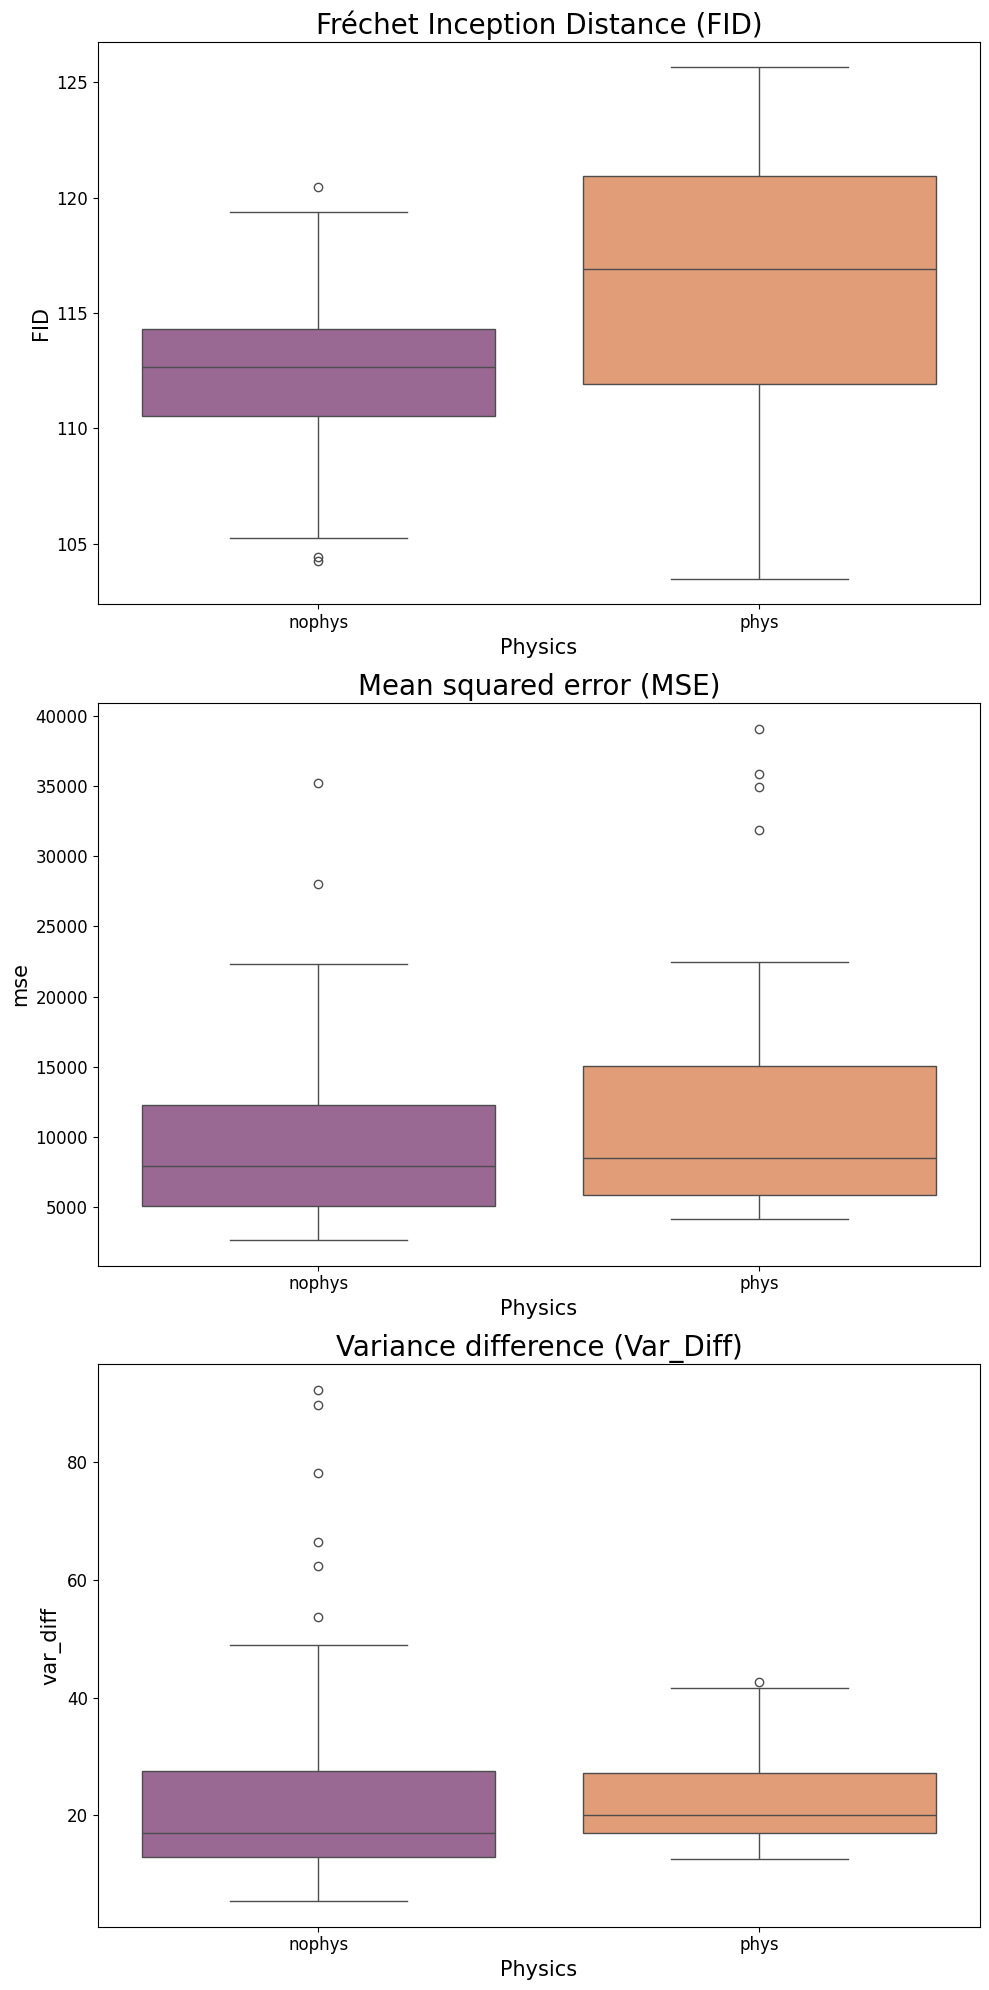

12:05:21 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2927737/3979261738.py:38: UserWarning: 
The palette list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  b = sns.boxplot(x='CFG', y=metric, data=df_combined, palette=pastel_palette, hue='CFG', legend=False)
12:05:21 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
12:05:21 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2927737/3979261738.py:38: UserWarning: 
The palette list has fewer values (2) than needed (8

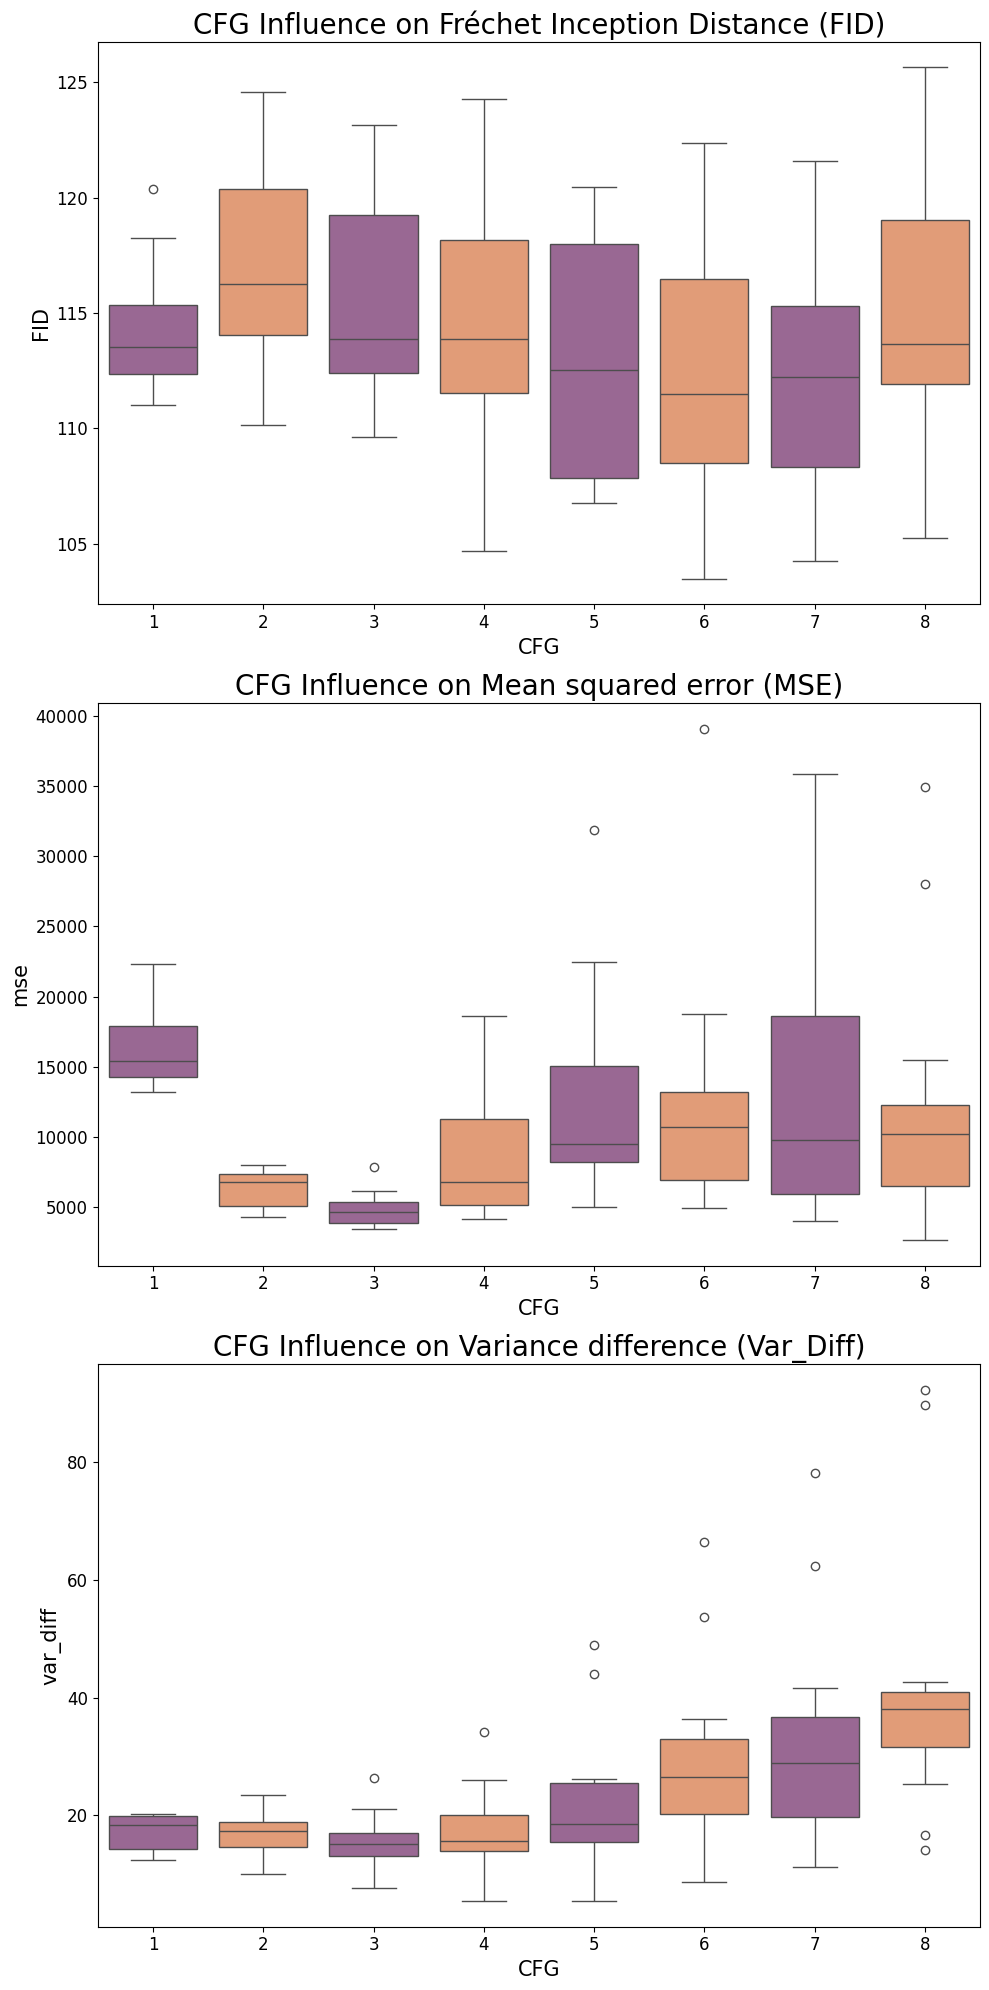

/tmp/ipykernel_2927737/3979261738.py:51: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  b = sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)
/tmp/ipykernel_2927737/3979261738.py:51: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  b = sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)
/tmp/ipykernel_2927737/3979261738.py:51: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  b = sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)


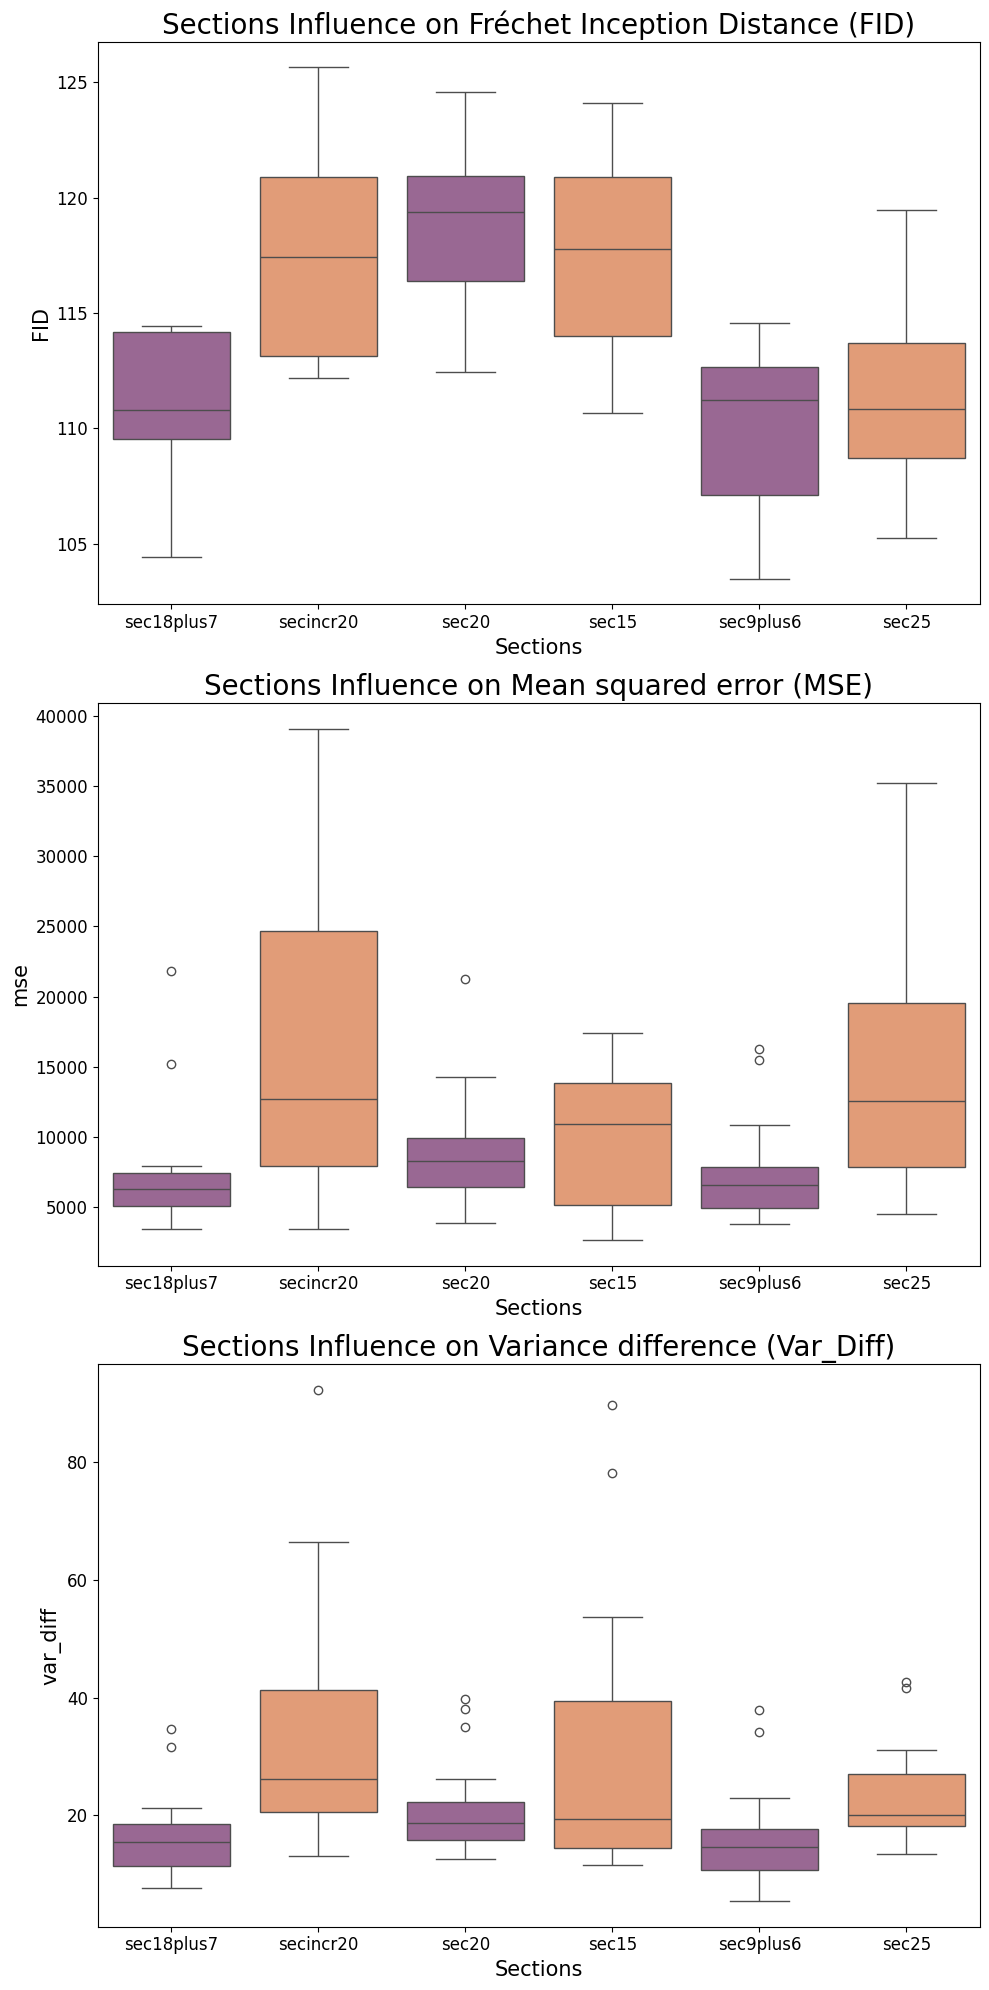

<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import *

def to_pastel(color, weight=0.3):
    """ Blend color with white to create a pastel shade """
    white = np.array([1, 1, 1])
    color = np.array(color)
    return list((1 - weight) * color + weight * white)

# Adjusting color palette for distinct model types
metrics = ['FID', 'mse', 'var_diff']
original_palette = sns.color_palette('inferno', n_colors=len(df_combined['Physics'].unique()))
pastel_palette = [to_pastel(color) for color in original_palette]
titles = ['Fréchet Inception Distance (FID)', 'Mean squared error (MSE)', 'Variance difference (Var_Diff)']


print(df_combined.dtypes)
# Creating plots for FID, MSE, MSE_Norm, and Var_Diff with distinct colors
plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    b = sns.boxplot(x='Physics', y=metric, data=df_combined, palette=pastel_palette, hue='Physics')
    b.set_xlabel('Physics', fontsize=15)
    b.set_ylabel(metric, fontsize=15)
    b.tick_params(labelsize=12)
    plt.title(titles[i], fontsize=20)

plt.tight_layout()
plt.show()

# Creating plots comparing the influence of CFG and Sections (sec) on the different metrics
# CFG influence
plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    b = sns.boxplot(x='CFG', y=metric, data=df_combined, palette=pastel_palette, hue='CFG', legend=False)
    b.set_xlabel('CFG', fontsize=15)
    b.set_ylabel(metric, fontsize=15)
    b.tick_params(labelsize=12)
    plt.title(f'CFG Influence on {titles[i]}', fontsize=20)

plt.tight_layout()
plt.show()

# Sections influence
plt.figure(figsize=(10, 20))
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    b = sns.boxplot(x='Sections', y=metric, data=df_combined, palette=pastel_palette, hue='Sections', legend=False)
    b.set_xlabel('Sections', fontsize=15)
    b.set_ylabel(metric, fontsize=15)
    b.tick_params(labelsize=12)
    plt.title(f'Sections Influence on {titles[i]}', fontsize=20)

plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 20))
# for i, metric in enumerate(metrics):
#     plt.subplot(len(metrics), 1, i+1)
#     b = sns.boxplot(x='Noise Steps', y=metric, data=df_combined, palette=pastel_palette, hue='Noise Steps', legend=False)
#     b.set_xlabel('Noise Steps', fontsize=15)
#     b.set_ylabel(metric, fontsize=15)
#     b.tick_params(labelsize=12)
#     plt.title(f'Noise steps influence on {titles[i]}', fontsize=20)

plt.tight_layout()
plt.show()


In [38]:
median = df_combined.groupby(['Sections', 'Model Type'])['Var_Diff'].median()
var = df_combined.groupby(['Sections', 'Model Type'])['Var_Diff'].var()

print(median)
print(var)

Sections  Model Type    
15        nophys            78.041923
          phys_spec         96.998744
          phys_spec_beam    64.405023
18+7      nophys            62.932719
          phys_spec         70.263410
          phys_spec_beam    43.312299
25        nophys            76.267794
          phys_spec         65.643661
          phys_spec_beam    51.425156
45        nophys            78.830177
          phys_spec         55.453660
          phys_spec_beam    53.542898
9+6       nophys            60.266710
          phys_spec         56.159075
          phys_spec_beam    45.200768
Name: Var_Diff, dtype: float64
Sections  Model Type    
15        nophys            3464.703880
          phys_spec         4207.261448
          phys_spec_beam    3554.140822
18+7      nophys             773.913230
          phys_spec         3374.559648
          phys_spec_beam     422.908783
25        nophys            5364.607871
          phys_spec         1123.318405
          phys_spec_beam    3

1
2
3


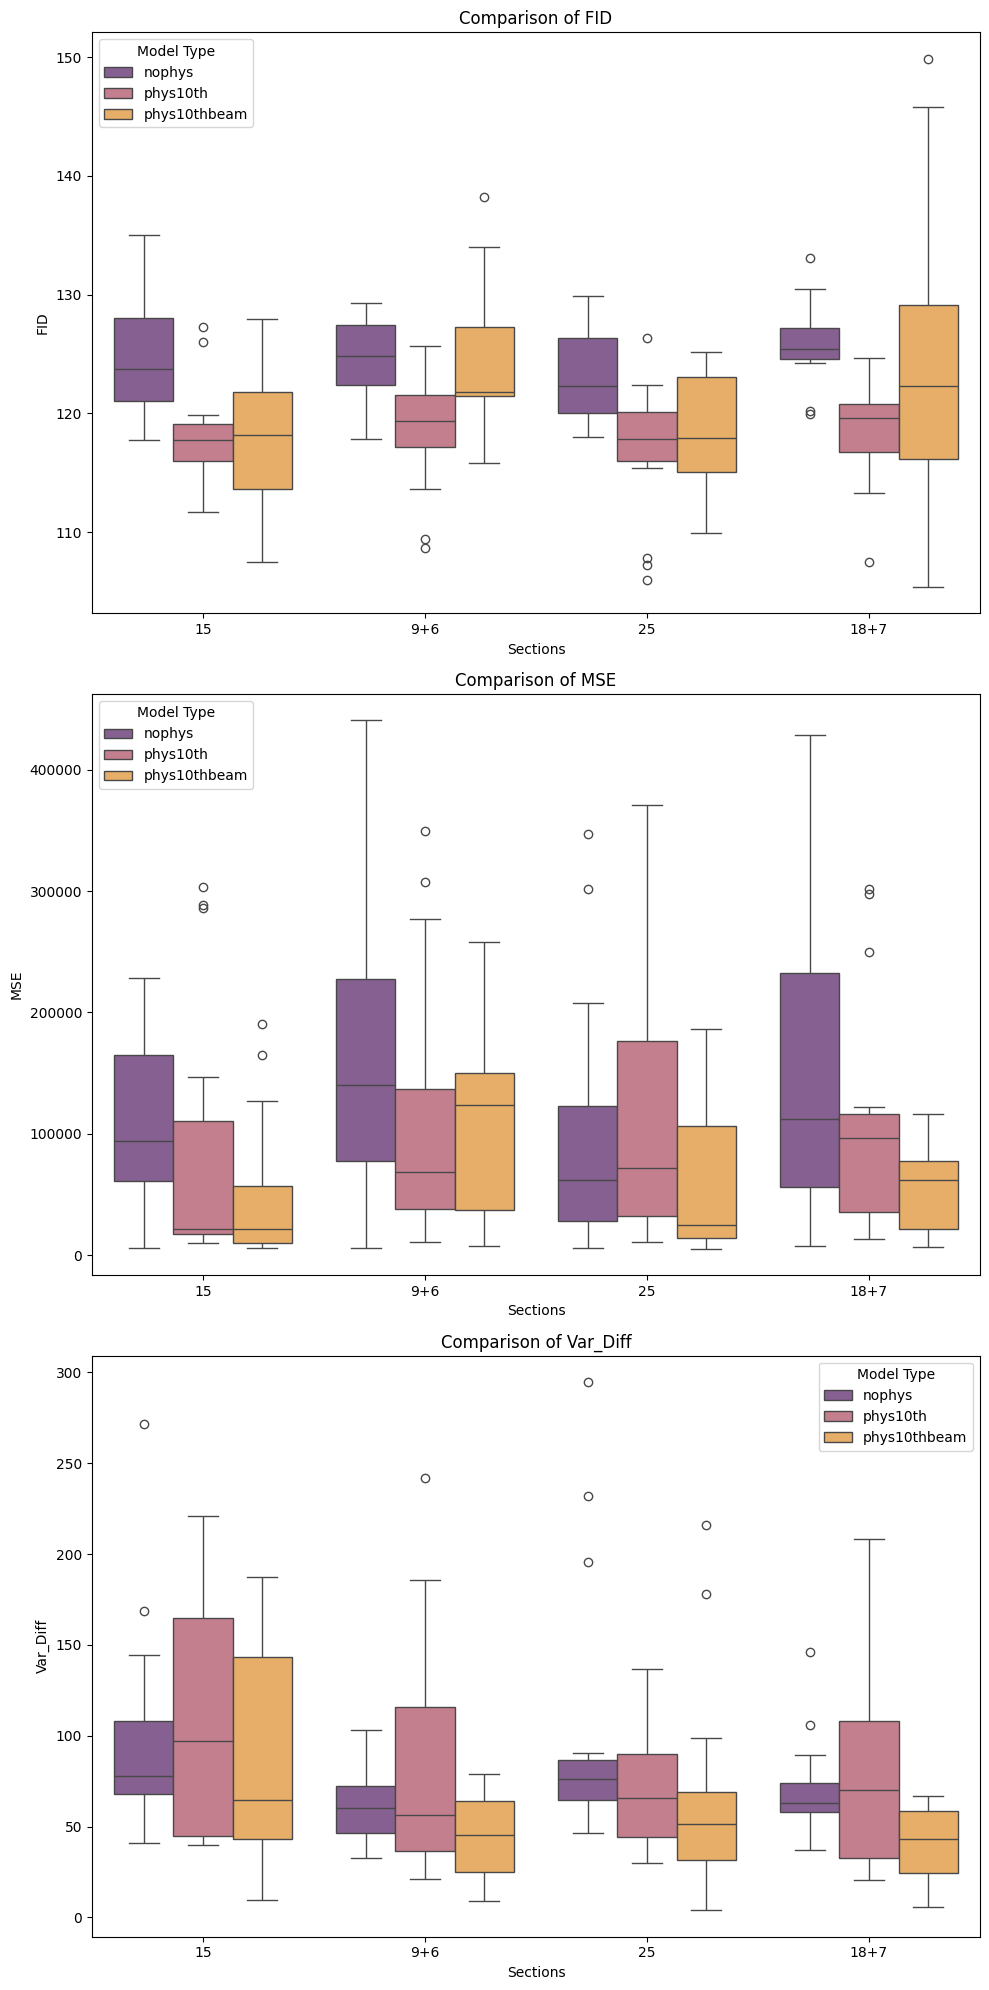

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparing data for the specified comparisons
# Combining sections as per the user's request
data = pd.read_csv('combined.csv')
# data['Combined Sections'] = data['Sections'].replace({'9': '9+6', '6': '9+6', '18': '18+7', '7': '18+7'})

# Filtering data for the required comparisons
comparison_groups = ['9+6', '15', '18+7', '25']
filtered_data = data[data['Sections'].isin(comparison_groups)]

def to_pastel(color, weight=0.3):
    """ Blend color with white to create a pastel shade """
    white = np.array([1, 1, 1])
    color = np.array(color)
    return list((1 - weight) * color + weight * white)

# Adjusting color palette for distinct model types
metrics = ['FID', 'MSE', 'Var_Diff']
original_palette = sns.color_palette('inferno', n_colors=3)
pastel_palette = [to_pastel(color) for color in original_palette]

# Plotting box charts for each metric
plt.figure(figsize=(10, 20))

for i, metric in enumerate(metrics, 1):
    print(i)
    plt.subplot(len(metrics), 1, i)
    sns.boxplot(x='Sections', y=metric, hue='Model Type', data=filtered_data, palette=pastel_palette)
    plt.title(f'Comparison of {metric}')
    plt.xlabel('Sections')
    plt.ylabel(metric)
    plt.legend(title='Model Type')

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Assuming 'data' is your DataFrame and it's already loaded
# Replace 'path_to_your_file.csv' with your actual file path
data = pd.read_csv('combined.csv')

# Renaming model types
data['Model Type'] = data['Model Type'].replace({'phys10th': 'phys_spec', 'phys10thbeam': 'phys_spec_beam'})

# If you want to save the modified DataFrame to a new file
data.to_csv('combined.csv', index=False)


10:42:23 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:42:23 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


10:42:23 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:42:23 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:42:23 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:42:23 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


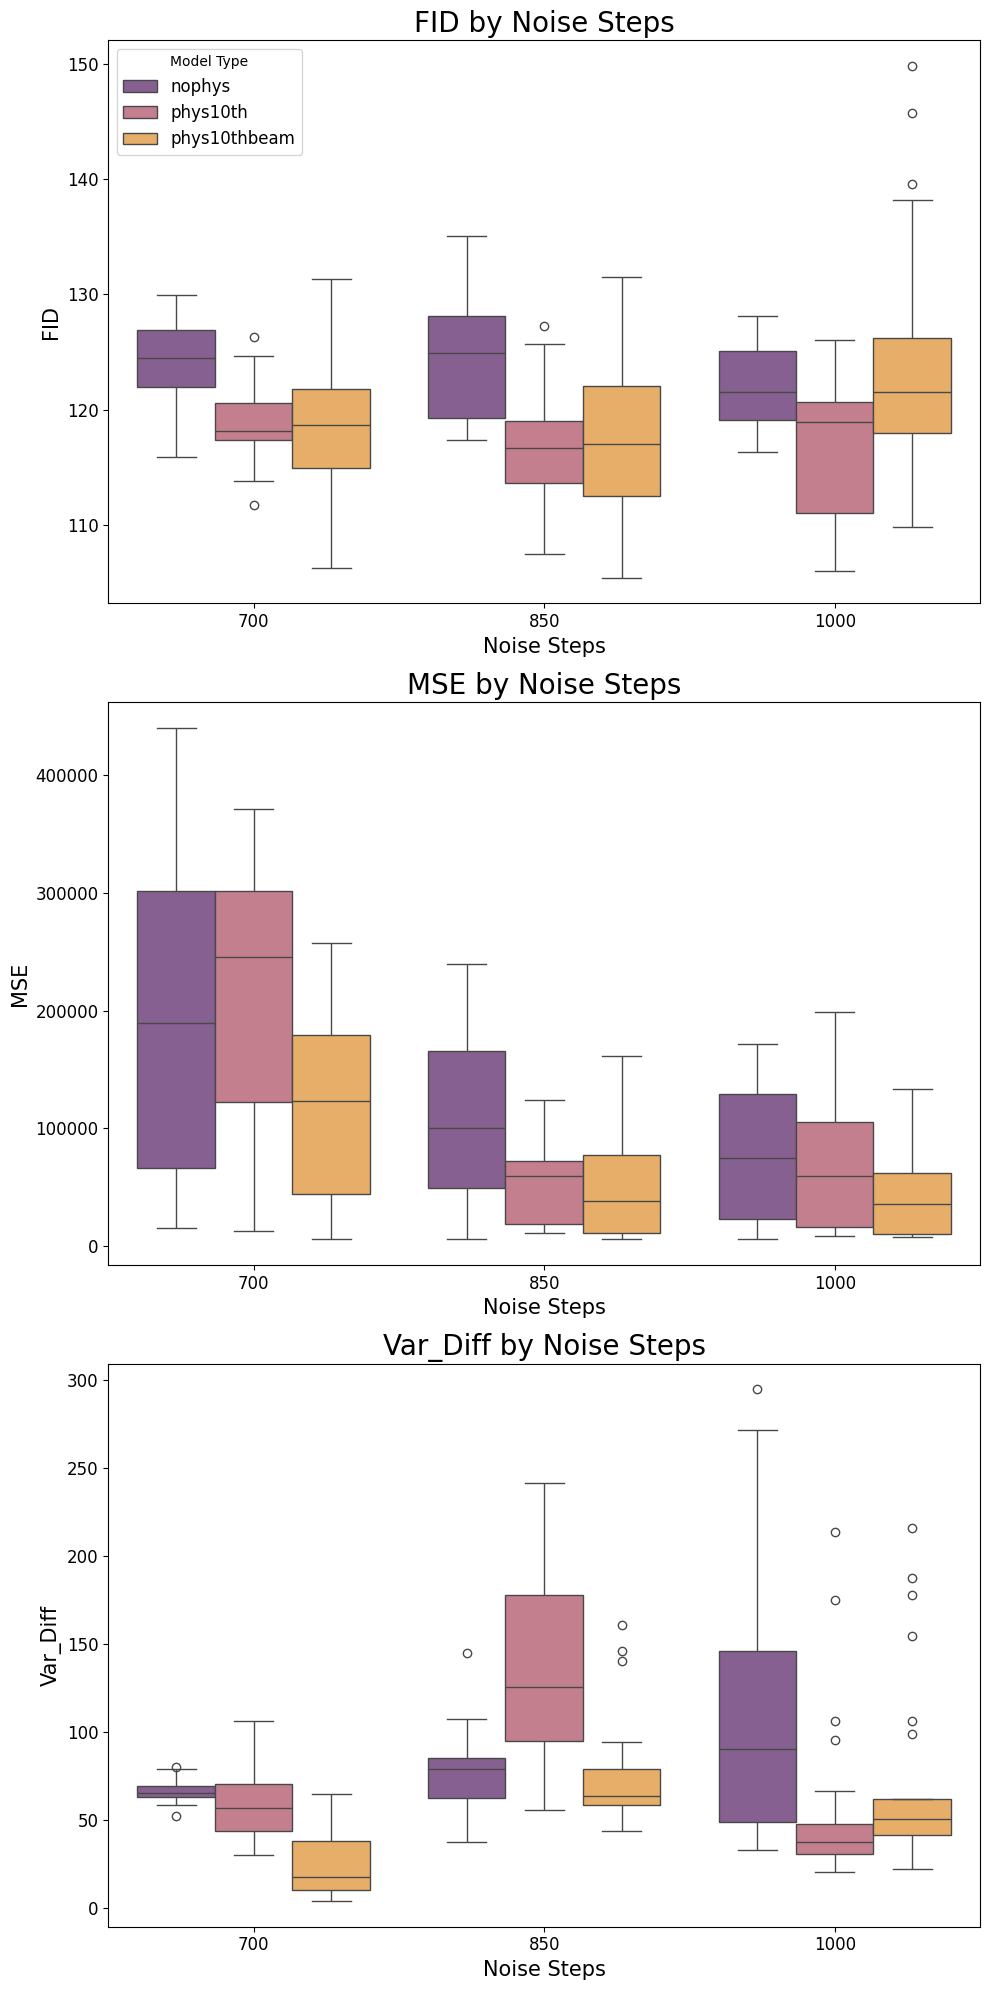

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your data
data = pd.read_csv('combined.csv')

# Metrics for subcharts
metrics_subcharts = ['FID', 'MSE', 'Var_Diff']

def to_pastel(color, weight=0.3):
    """ Blend color with white to create a pastel shade """
    white = np.array([1, 1, 1])
    color = np.array(color)
    return list((1 - weight) * color + weight * white)
original_palette = sns.color_palette('inferno', n_colors=3)
pastel_palette = [to_pastel(color) for color in original_palette]

parameter = 'Noise Steps'


fig, axes = plt.subplots(len(metrics_subcharts), 1, figsize=(10, 20))
for j, metric in enumerate(metrics_subcharts):
    b = sns.boxplot(ax=axes[j], x=parameter, y=metric, hue='Model Type', data=data, palette=pastel_palette)
    axes[j].set_title(f'{metric} by {parameter}', fontsize=20)
    axes[j].set_xlabel(parameter, fontsize=15)
    axes[j].set_ylabel(metric, fontsize=15)
    b.tick_params(labelsize=12)
    if j != 0:  # Adjusting the condition to keep the legend in the first subplot
        axes[j].get_legend().remove()
    else:
        axes[j].legend(title='Model Type', fontsize=12)

plt.tight_layout()
plt.savefig(f'{parameter}_metrics.png')  # Save the figure after displaying
plt.show()
plt.close()


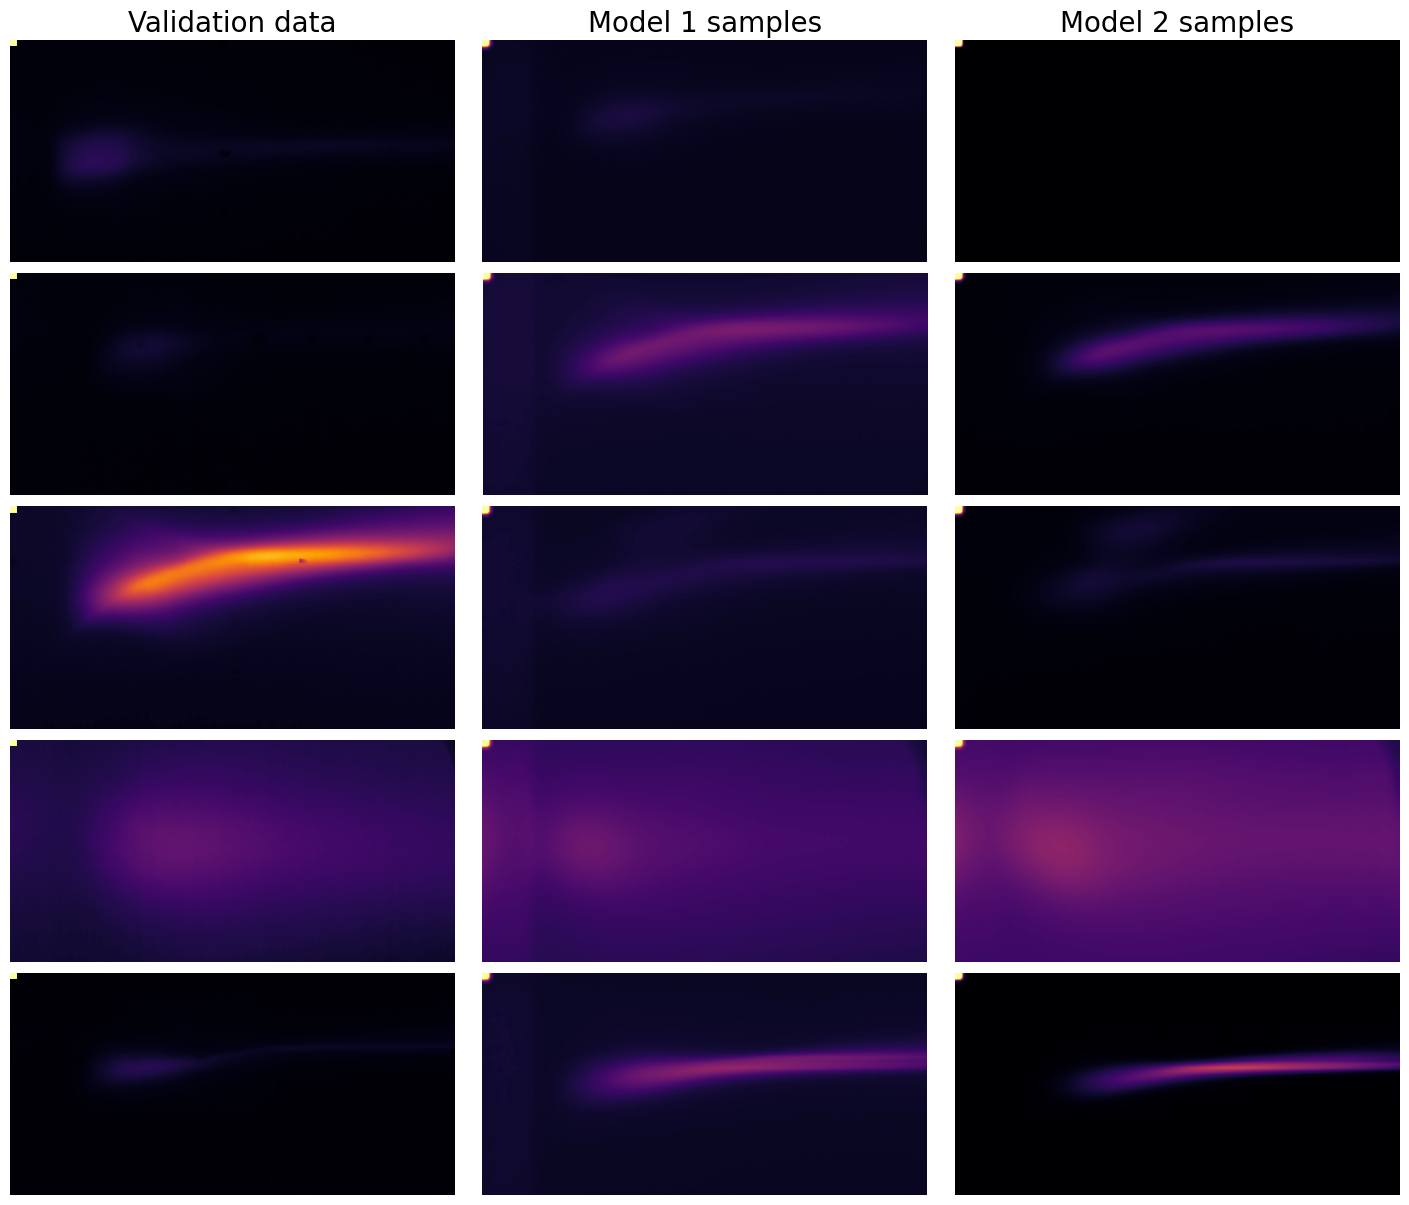

In [13]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

def calculate_average_image(folder):
    """ Calculate the average image from all images in a folder """
    images = []
    for file_name in os.listdir(folder):
        if file_name.endswith('.png'):  # Assuming images are in PNG format
            img_path = os.path.join(folder, file_name)
            img = Image.open(img_path)
            img = np.array(img)
            images.append(img)

    return np.clip(np.mean(images, axis=0)*2, 0, 255) if images else None

def compare_avg_plot(folder1, folder2, folder3):
    # Find common subfolders
    common_subfolders = set(os.listdir(folder1)).intersection(os.listdir(folder2), os.listdir(folder3))
    
    num_subfolders = len(common_subfolders)
    if num_subfolders == 0:
        print("No common subfolders found.")
        return

    fig, axs = plt.subplots(num_subfolders, 3, figsize=(18, 3 * num_subfolders))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Decreased vertical space

    for i, subfolder in enumerate(common_subfolders):
        avg_img1 = calculate_average_image(os.path.join(folder1, subfolder))
        avg_img2 = calculate_average_image(os.path.join(folder2, subfolder))
        avg_img3 = calculate_average_image(os.path.join(folder3, subfolder))

        if avg_img1 is not None and avg_img2 is not None and avg_img3 is not None:
            axs[i, 0].imshow(avg_img1.astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 1].imshow(avg_img2.astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 2].imshow(avg_img3.astype(np.uint8), vmin=0, vmax=255, cmap='inferno')

            for j in range(3):
                axs[i, j].axis('off')
                if i == 0:  # Set titles only for the top row
                    titles = ['Validation data', 'Model 1 samples', 'Model 2 samples']
                    axs[i, j].set_title(titles[j], fontsize=20)

    plt.show()

# Example usage
compare_avg_plot('data/with_gain', 'results/valid_phys10th_beam_850ns_sec2x9plus7_cfg1', 'results/valid_phys10th_1000ns_sec2x9plus7_cfg3')


In [11]:
from metrics import *
print(np.mean(calculate_pixelwise_variance('data/with_gain/3')))
print(np.mean(calculate_pixelwise_variance('data/with_gain/8')))
print(np.mean(calculate_pixelwise_variance('data/with_gain/11')))
print(np.mean(calculate_pixelwise_variance('data/with_gain/19')))
print(np.mean(calculate_pixelwise_variance('data/with_gain/21')))

1.5134900888742606
11.572971966552732
1.1828602032580007
3.8697496809270846
17.286125189593047


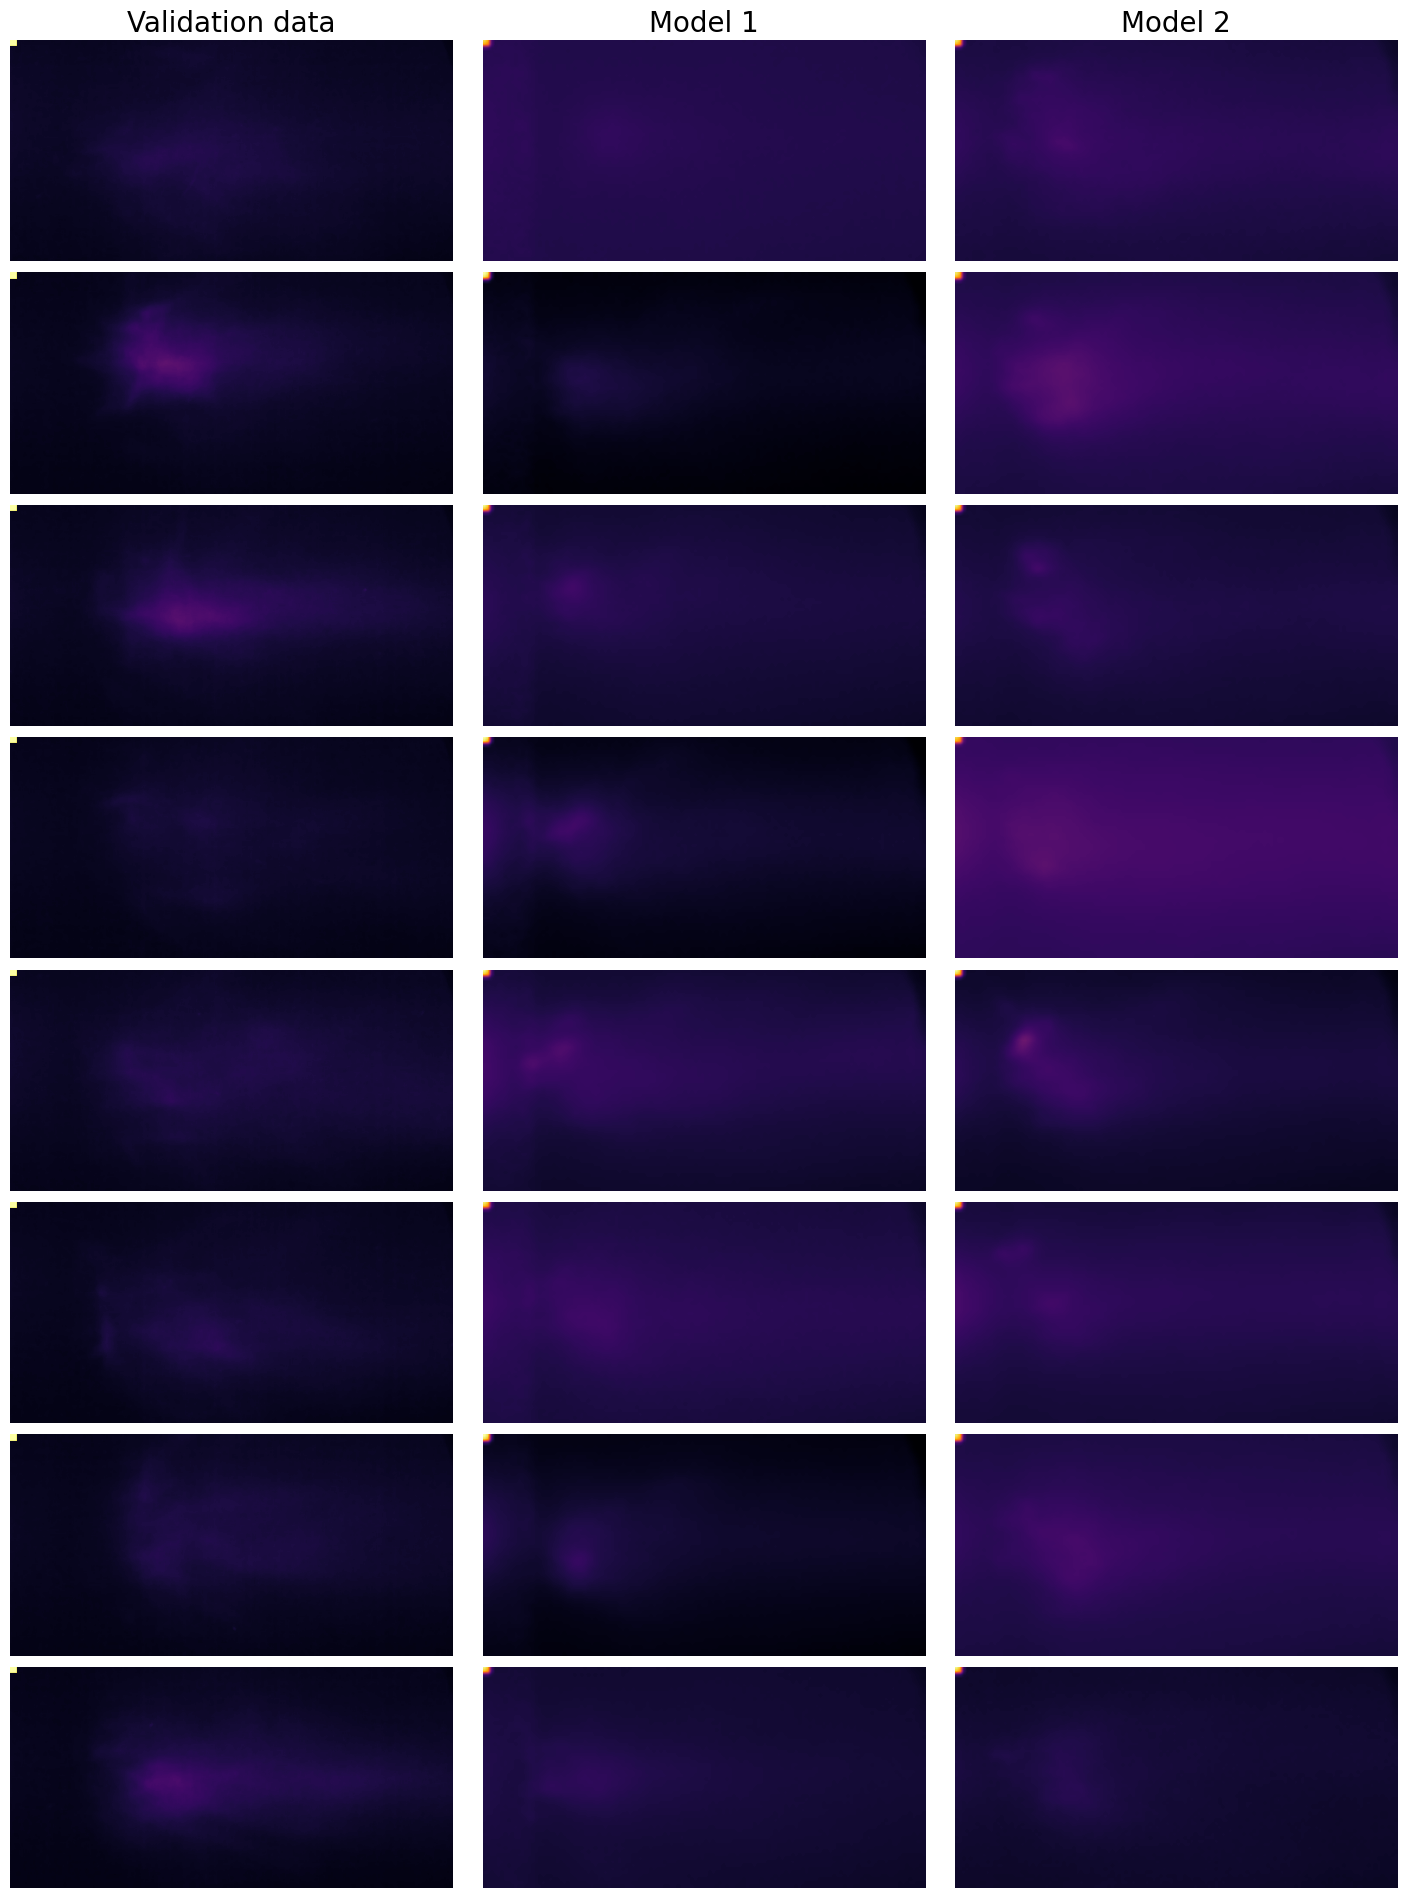

In [12]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import random

def load_random_images(folder, n):
    """ Load n random images from a folder """
    images = []
    all_files = [f for f in os.listdir(folder) if f.endswith('.png')]
    selected_files = random.sample(all_files, min(n, len(all_files)))

    for file_name in selected_files:
        img_path = os.path.join(folder, file_name)
        img = Image.open(img_path)
        img = np.array(img).astype(np.uint16)
        images.append(np.clip(img*1, 0, 255).astype(np.uint8))

    return images

def compare_random_images(folder1, folder2, folder3, n):
    images1 = load_random_images(folder1, n)
    images2 = load_random_images(folder2, n)
    images3 = load_random_images(folder3, n)

    fig, axs = plt.subplots(n, 3, figsize=(18, 3 * n))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i in range(n):
        if i < len(images1):
            axs[i, 0].imshow(images1[i].astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 0].axis('off')
        if i < len(images2):
            axs[i, 1].imshow(images2[i].astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 1].axis('off')
        if i < len(images3):
            axs[i, 2].imshow(images3[i].astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 2].axis('off')

    axs[0, 0].set_title('Validation data', fontsize=20)
    axs[0, 1].set_title('Model 1', fontsize=20)
    axs[0, 2].set_title('Model 2', fontsize=20)

    plt.show()
# validate on: 3, 8, 11, 19, 21
# 1.5134900888742606
# 11.572971966552732
# 1.1828602032580007
# 3.8697496809270846
# 17.286125189593047
exp_num = 21
# Example usage
compare_random_images('data/with_gain/' + str(exp_num),
                      'results/valid_phys10th_beam_850ns_sec2x9plus7_cfg1/' + str(exp_num),
                      'results/valid_phys10th_1000ns_sec2x9plus7_cfg3/' + str(exp_num),
                      n=8)


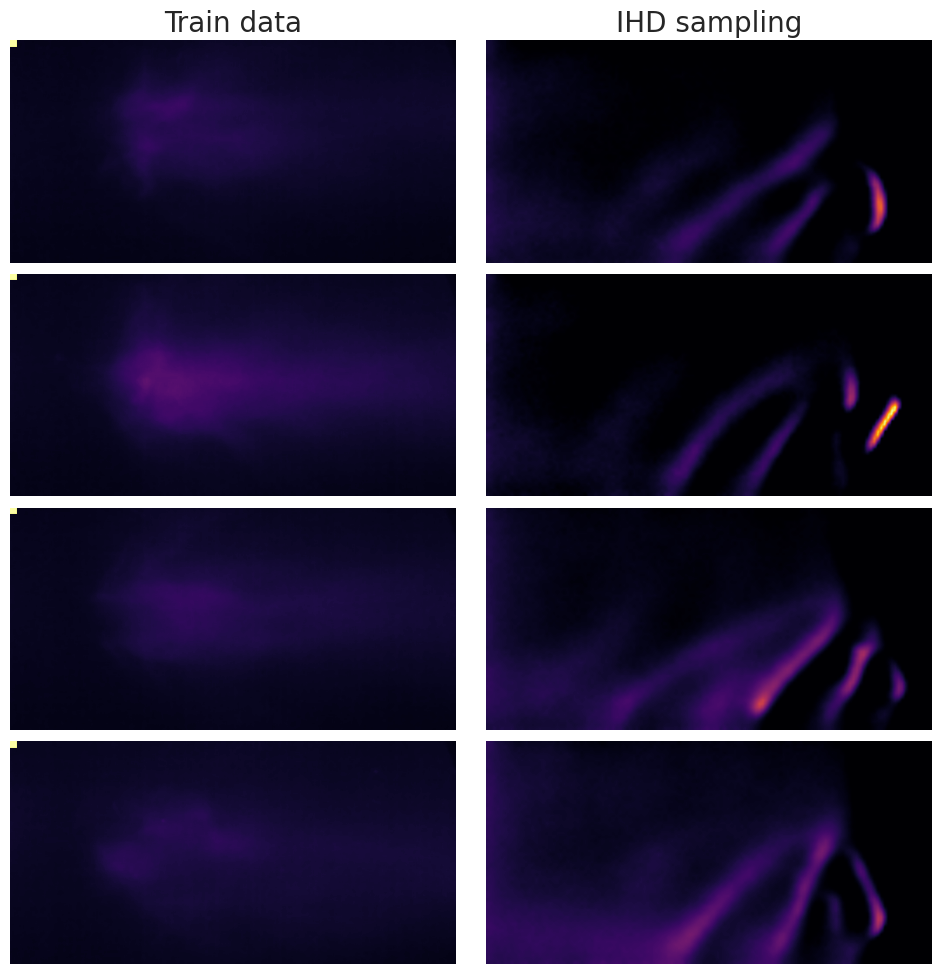

In [32]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import random

def load_random_images(folder, n):
    """ Load n random images from a folder """
    images = []
    all_files = [f for f in os.listdir(folder) if f.endswith('.png')]
    selected_files = random.sample(all_files, min(n, len(all_files)))

    for file_name in selected_files:
        img_path = os.path.join(folder, file_name)
        img = Image.open(img_path)
        img = np.array(img).astype(np.uint16)
        images.append(np.clip(img*1, 0, 255).astype(np.uint8))

    return images

def compare_random_images(folder1, folder2, n):
    images1 = load_random_images(folder1, n)
    images2 = load_random_images(folder2, n)

    fig, axs = plt.subplots(n, 2, figsize=(12, 3 * n))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i in range(n):
        if i < len(images1):
            axs[i, 0].imshow(images1[i].astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 0].axis('off')
        if i < len(images2):
            axs[i, 1].imshow(images2[i].astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 1].axis('off')

    axs[0, 0].set_title('Train data', fontsize=20)
    axs[0, 1].set_title('IHD sampling', fontsize=20)

    plt.show()
# validate on: 3, 8, 11, 19, 21
# 1.5134900888742606
# 11.572971966552732
# 1.1828602032580007
# 3.8697496809270846
# 17.286125189593047
exp_num = 21
# Example usage
compare_random_images('data/with_gain/' + str(exp_num),
                      'res_IHD_21',
                      n=4)


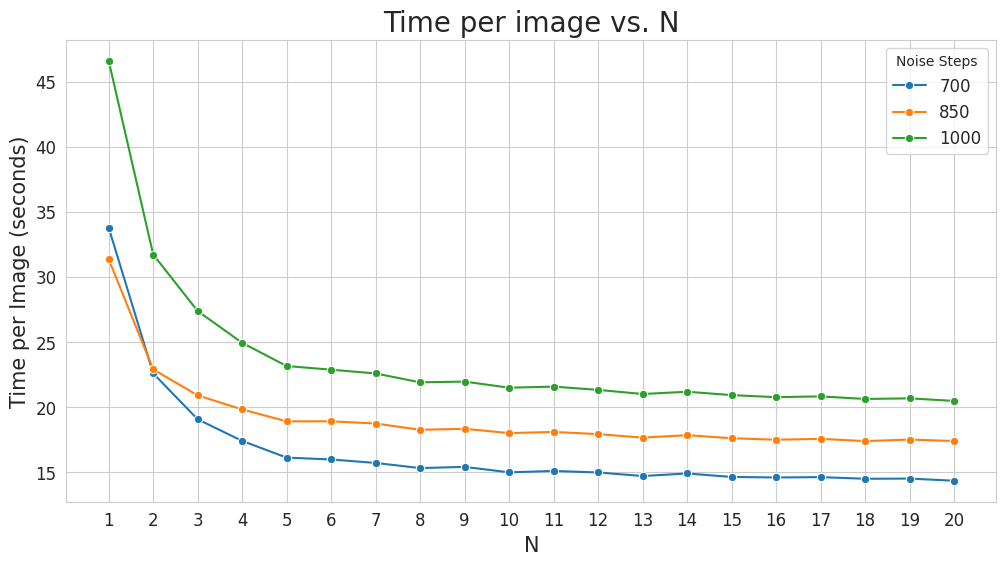

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your data
file_path = 'execution_time_analysis_diffusion.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating the line plot with integer ticks on the x-axis
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='N', y='Time per Image (seconds)', hue='Noise Steps', palette='tab10', marker='o')
plt.title('Time per image vs. N', fontsize=20)
plt.xlabel('N', fontsize=15)
plt.ylabel('Time per Image (seconds)', fontsize=15)
plt.xticks(range(int(data['N'].min()), int(data['N'].max()) + 1), fontsize=12)  # Setting x-axis ticks to integers
plt.yticks(fontsize=12)
plt.legend(title='Noise Steps', fontsize=12)
plt.show()


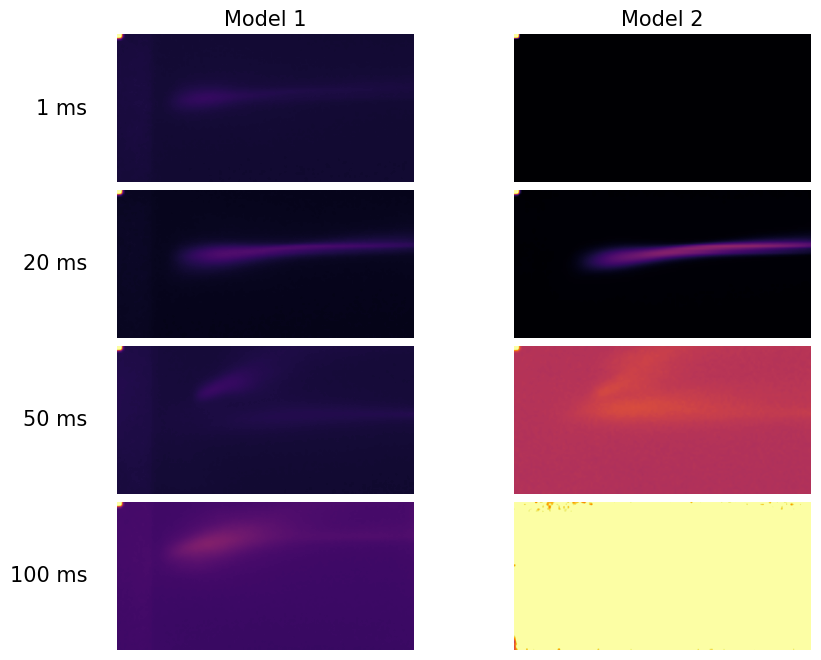

In [5]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

def calculate_average_image(folder):
    """ Calculate the average image from all images in a folder """
    images = []
    for file_name in os.listdir(folder):
        if file_name.endswith('.png'):  # Assuming images are in PNG format
            img_path = os.path.join(folder, file_name)
            img = Image.open(img_path)
            img = np.array(img)
            images.append(img)

    return np.clip(np.mean(images, axis=0)*2, 0, 255) if images else None

def compare_avg_plot(folder1, folder2):
    # Find common subfolders
    common_subfolders = set(os.listdir(folder1)).intersection(os.listdir(folder2))
    
    num_subfolders = len(common_subfolders)
    if num_subfolders == 0:
        print("No common subfolders found.")
        return

    fig, axs = plt.subplots(num_subfolders, 2, figsize=(10, 2 * num_subfolders))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Decreased vertical space
    acquisitions = ['1 ms', '20 ms', '50 ms', '100 ms']
    for i, subfolder in enumerate(sorted(common_subfolders)):
        
        avg_img1 = calculate_average_image(os.path.join(folder1, subfolder))
        avg_img2 = calculate_average_image(os.path.join(folder2, subfolder))

        if avg_img1 is not None and avg_img2 is not None:
            axs[i, 0].imshow(avg_img1.astype(np.uint8), vmin=0, vmax=255, cmap='inferno')
            axs[i, 1].imshow(avg_img2.astype(np.uint8), vmin=0, vmax=255, cmap='inferno')

            for j in range(2):
                axs[i, j].axis('off')
                if i == 0:  # Set titles only for the top row
                    titles = ['Model 1', 'Model 2']
                    axs[i, j].set_title(titles[j], fontsize=15)

            # Add text to the left of the first image
            axs[i, 0].text(-0.1, 0.5, acquisitions[i], transform=axs[i, 0].transAxes, 
                           ha="right", va="center", fontsize=15, rotation=0)

    plt.show()


    plt.show()

# Example usage
compare_avg_plot('model1', 'model2')


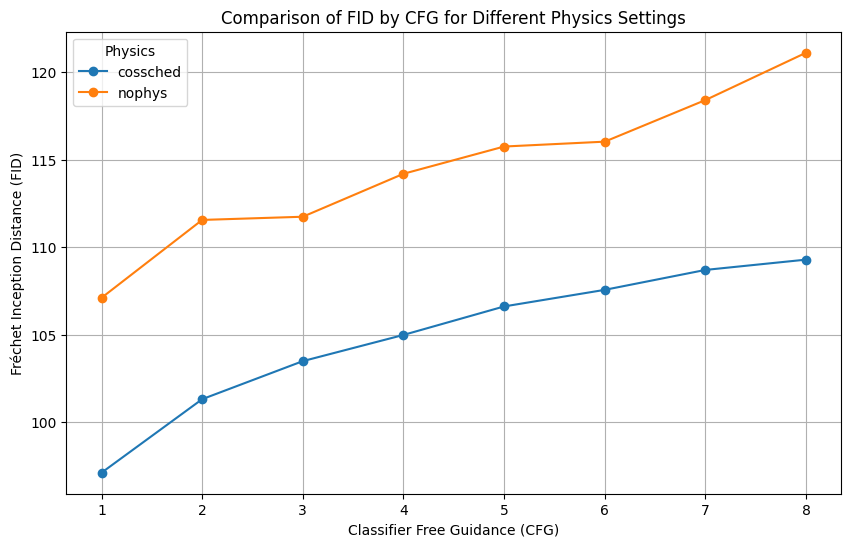

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file to examine its structure
file_path = 'metrics_600e.csv'
data = pd.read_csv(file_path)
# Filter and group data
grouped_data = data.groupby(['Physics', 'CFG'])['FID'].mean().unstack(level=0)

# Plotting
plt.figure(figsize=(10, 6))
for label in grouped_data.columns:
    plt.plot(grouped_data.index, grouped_data[label], label=label, marker='o')
plt.title('Comparison of FID by CFG for Different Physics Settings')
plt.xlabel('Classifier Free Guidance (CFG)')
plt.ylabel('Fréchet Inception Distance (FID)')
plt.legend(title='Physics')
plt.grid(True)
plt.show()


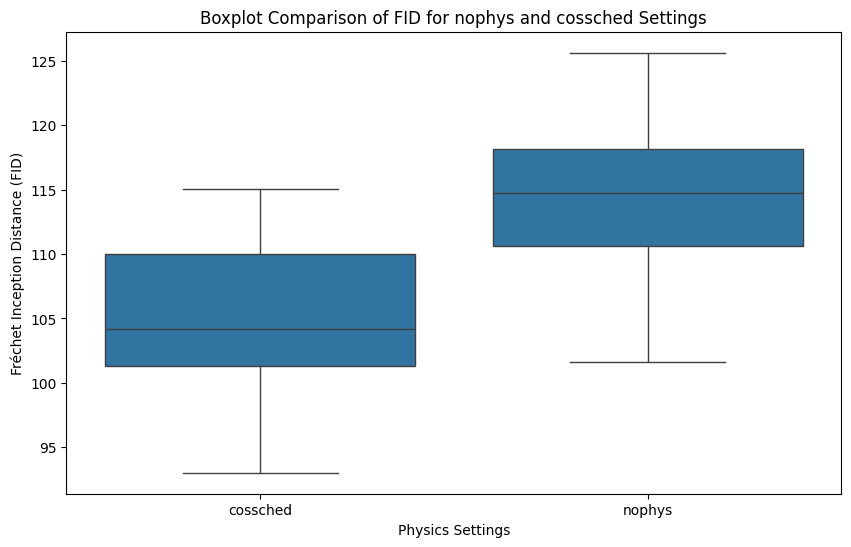

In [2]:
import seaborn as sns

# Setting up the boxplot for FID comparison between nophys and cossched
plt.figure(figsize=(10, 6))
sns.boxplot(x='Physics', y='FID', data=data)
plt.title('Boxplot Comparison of FID for nophys and cossched Settings')
plt.xlabel('Physics Settings')
plt.ylabel('Fréchet Inception Distance (FID)')
plt.show()


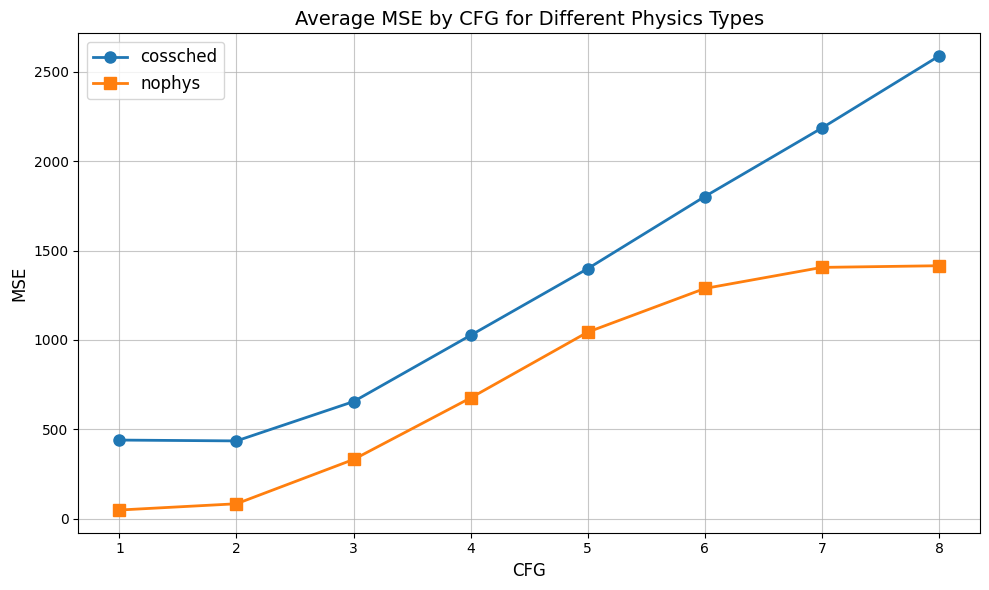


Average MSE by Physics Type:
Physics
cossched    1316.486334
nophys       786.121771
Name: mse, dtype: float64


<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv('metrics_600e.csv')

# Group by Physics and CFG, and calculate mean MSE
grouped = df.groupby(['Physics', 'CFG'])['mse'].mean().reset_index()

# Create separate dataframes for each Physics type
cossched_data = grouped[grouped['Physics'] == 'cossched']
nophys_data = grouped[grouped['Physics'] == 'nophys']

# Sort by CFG for proper line plotting
cossched_data = cossched_data.sort_values('CFG')
nophys_data = nophys_data.sort_values('CFG')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cossched_data['CFG'], cossched_data['mse'], 'o-', linewidth=2, markersize=8, label='cossched')
plt.plot(nophys_data['CFG'], nophys_data['mse'], 's-', linewidth=2, markersize=8, label='nophys')

# Add labels and title
plt.xlabel('CFG', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Average MSE by CFG for Different Physics Types', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.7)

# Set the x-axis to only show integer values
plt.xticks(sorted(df['CFG'].unique()))

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot as an image file
plt.savefig('mse_vs_cfg_by_physics.png', dpi=300)

# Print average MSE for each physics type (optional)
print("\nAverage MSE by Physics Type:")
print(df.groupby('Physics')['mse'].mean())